# Main settings for this notebook

The model used for N-body simulations of the Random Recurrent Neural Network (hereinafter RRNN) is:

\begin{equation}
  x_i(t+1) = x_i(t) + \sum_{j=1}^N J_{ij}\phi(c(x_j(t)-\theta)) + \xi_{\rm C}(t) + \xi_i(t) + \mu_i
\end{equation}
$\xi_i$ and $\mu_i$ are independent white and quenched random inputs, and where $\xi_{\rm C}$ is a common noise source. 

Notation:
- sigma_common is the variance of $\xi_{\rm C}$ , which is white noise inputted to all the neurons. 
- sigma_ind is the variance of $\xi_i(t)$　or $\mu_i$
- sigma_quench is  the variance of $\mu_i$

The weights $J_{ij}$ are i.i.e.  Gaussian random variables whose scale and bias is determined by the parameters g_scale and J_bias, that is,  $ \sim \mathcal{N}(J_{\rm bias}/N, g^2_{\rm scale}/N)$ .

act_type $=1$: $\phi(x) = \tanh(x)$

act_type $=2$: $\phi(x) = \frac{1}{2}\left(\tanh(x)+ 1\right)$

act_type $=3$: ReLU

To construct a RNN, we further have to set:
-  neuron_n $= N$: the number of neurons
- time_slice $=dt$
- step_n $=T/dt$: where $dt$ is time slice for Eulerian discretization and $T$ is the duration of a simulation.


# Outline of the notebook

    
    1. Prepare classes for N-body simulations and DMFT computations
    2. Test the N-body simulation
    3. Visualize results obtained by N-body simulation 
    4. Test the DMFT
    5. Visualize results of the DMFT tests and compare them  with those of the N-body simulation 
    6. Obtain bifurcation diagram from DMFT and plot  the maximal Lyapunov exponent
    7. Obtain bifurcation diagram from the N-body simulation with an adiabatic variation of parameters 
    8. Compare bifurcation diagrams obtained through DMFT and N-body simulation

# Setting up the  device

In [1]:
import torch 

## set a precision type
precision = torch.double

## check if a GPU is available
if(torch.cuda.is_available()):
  print("GPU available: "+torch.cuda.get_device_name())
  dev = "cuda:0"
else:
  print("No GPU available... Using CPU.")
  dev = "cpu:0"
device = torch.device(dev)
torch.cuda.empty_cache()

No GPU available... Using CPU.


# Preparing classes for N-body simulations and DMFT calculations 


In [2]:
"""
Classes for the N-body simulations and the mean-field theoretical anaysis for the RRNN

"""
class RecurentRandomNeuralNetworkNbody:
    """
    N-body neural network settings
    """
    def __init__(self,neuron_n,replica_n,step_n,time_slice,act_type):
        self.neuron_n = neuron_n      # number of neurons 
        self.replica_n = replica_n    # number of replicas
        self.step_n = step_n          # number of iterations
        self.time_slice = time_slice  # dt in the discretized ODE
        self.act_type = act_type      # act_type = 1(tanh), 2(sigmoid), 3(ReLU)
    #activation function
    def activation_phi(self,x):
        if self.act_type == 1:
            return torch.tanh(x)
        if self.act_type == 2:
            return 0.5*torch.tanh(x)+0.5
        if self.act_type == 3:
            y = x
            y[y<=0] = 0
            return y
        else:
            print("choose activation function from options {1, 2, 3}.")
            
    def activation_derphi(self,x):
        if self.act_type == 1:
            return 1.0/torch.cosh(x)/torch.cosh(x)
        if self.act_type == 2:
            return 0.5/torch.cosh(x)/torch.cosh(x)
        if self.act_type == 3:
            y = 1
            y[y<=0] = 0
            return y
        else:
            print("choose activation function from options {1, 2, 3}.")

    #generate random numbers from a normal distribution
    def rand_gauss(self, N, M=1):
        return torch.randn(N,M, dtype=precision, device=device)
    
    #synaptic weights 
    def rand_network(self,N,M=1):
            return self.rand_gauss(N,M)    
    
    #numerical integration of RRNN
    def evolve_rrnn(self, g_scale, J_bias, theta, c = 1, sigma_ind = 0, sigma_quench = 0, sigma_common = 0, 
                    initial_var=1.0,J = []):
        dt = self.time_slice
        N = self.neuron_n
        T = self.step_n
        X = torch.zeros((N, T+1), device=device, dtype=precision)
        #prepare the weights
        if(J==[]):
                J = (g_scale/np.sqrt(N))*self.rand_gauss(N,N)+J_bias*torch.ones(N,N,device=device)/N
        for i in range(N):
            J[i][i]=0.0
        #prepare the initial conditions
        X[:,0] = torch.randn(N,device=device)*np.sqrt(initial_var)
        quench_noise = sigma_quench*self.rand_gauss(1,N)
        for i in tqdm(range(T)):
            X[:,i+1] = (1-dt)*X[:,i] + torch.matmul(J,self.activation_phi(c*(X[:,i]- theta)))*dt+sigma_ind*self.rand_gauss(1,N)*np.sqrt(dt) + quench_noise*dt
        return X,c*J*self.activation_phi(c*(X[:,T-1]- theta))
    
    # code to generate the histeresis loop
    # sigma_move is the amplitude of the oscillating sigma used to obtain histeresis

    def evolve_rrnn_loop(self, g_scale, J_bias, theta, c = 1,sigma_move=0,sigma_ind=0, sigma_quench=0, noise_type = 1,sigma_common = 0,initial_var=1.0, J = []):
        dt = self.time_slice
        N = self.neuron_n
        T = self.step_n
        X = torch.zeros((N, T+1), device=device, dtype=precision)
        #preparing the weights
        if(J==[]):
            J = (g_scale/np.sqrt(N))*self.rand_gauss(N,N)+J_bias*torch.ones(N,N,device=device)/N

        for i in range(N):
            J[i][i]=0.0
        sigma = torch.zeros(T+1, device = device, dtype=precision)
        #inititalizing
        X[:,0] = torch.randn(N,device=device)*initial_var

        if noise_type == 1:
            sigma[0]=sigma_ind #set initial value of sigma
            for i in range(T):
                sigma[i+1]=sigma_ind+sigma_move*(np.sin(2.0*np.pi*i/T-np.pi/2.0) + 1.0)
                X[:,i+1] = (1-dt)*X[:,i] + torch.matmul(J,self.activation_phi(c*(X[:,i]- theta)))*dt+sigma[i]*self.rand_gauss(1,N)*np.sqrt(dt)
        if noise_type == 2:
            sigma[0]=sigma_quench #set initial value of sigma
            quench_noise = self.rand_gauss(1,N)
            for i in tqdm(range(T)):
                sigma[i+1]=sigma_quench+sigma_move*(np.sin(2.0*np.pi*i/T-np.pi/2.0) + 1.0)
                X[:,i+1] = (1-dt)*X[:,i] + torch.matmul(J,self.activation_phi(c*(X[:,i]- theta)))*dt + sigma[i]*quench_noise*dt
        return X,sigma

    
"""
Class for the MFT analysis for the random neural network's static state
"""
class RecurentRandomNeuralNetworkMeanField:
    def __init__(self,step_n,act_type,error_integral,time_slice):
        self.step_n = step_n # number of steps, 
        self.error_integral = error_integral #integration tolerance 
        self.time_slice = time_slice #dt
        self.act_type = act_type 
    #act_type = 1 (tanh), 2(sigmoid), 3(ReLU)
    #activation function
    def activation_phi(self,x):
        if self.act_type == 1:
            return np.tanh(x)
        if self.act_type == 2:
            return 0.5*np.tanh(x)+0.5
        if self.act_type == 3:
            y = x
            y[y<=0] = 0
            return y
        else:
            print("choose activation function from {1, 2, 3}.")
    #derivative of activation functions, 
    #which is used for computing the largest Lyapunov exponent and for doing stability analysis, 
    def activation_dphi(self,x):
        if self.act_type == 1:
            return 1.0/np.cosh(x)/np.cosh(x)
        if self.act_type == 2:
            return 0.5/np.cosh(x)/np.cosh(x)
        if self.act_type == 3:
            if x > 0:
                y = 1.0
            else:
                y = 0.0
            return y
        else:
            print("choose activation function from {1, 2, 3}.")
 
    # antiderivative of activation function 
    def activation_aphi(self,x):
        if self.act_type == 1:
            return 1.0/np.cosh(x)/np.cosh(x)
        if self.act_type == 2:
            return 0.5/np.cosh(x)/np.cosh(x)
        if self.act_type == 3:
            if x > 0:
                y = 1.0
            else:
                y = 0.0
            return y
        else:
            print("choose activation function from {1, 2, 3}.")
    
    #normal distribution
    def normal_PDF(self,x):
        pi = np.pi
        return (1/np.sqrt(2*pi))*np.exp(-x*x/2)
    
    ## Input to the network, g is given in the code of N-body  simultaions
    def Input1(self,C_0,M_0,g_scale,J_bias,c,theta):
        y=lambda x: J_bias*self.activation_phi(c*(np.sqrt(C_0)*x+M_0-theta))*self.normal_PDF(x)
        iy,  err = integrate.quad(y,-np.inf,np.inf)
        return iy, err

    def dInput1(self,C_0,M_0,g_scale,J_bias,c,theta):
        y=lambda x: J_bias*c*self.activation_dphi(c*(np.sqrt(C_0)*x+M_0-theta))*self.normal_PDF(x)
        iy,  err = integrate.quad(y,-np.inf,np.inf)
        return iy, err

    def Input2(self,C_0,M_0,g_scale,J_bias,c,theta):
        y=lambda x: (g_scale**2)*(self.activation_phi(c*(np.sqrt(C_0)*x+M_0-theta)))**2*self.normal_PDF(x)
        iy,  err = integrate.quad(y,-np.inf,np.inf)
        return iy, err

    def dInput2(self,C_0,M_0,g_scale,J_bias,c,theta):
        y=lambda x: (g_scale**2)*(c**2)*(self.activation_dphi(c*(np.sqrt(C_0)*x+M_0-theta)))**2*self.normal_PDF(x)
        iy,  err = integrate.quad(y,-np.inf,np.inf)
        return iy, err

    def evolve_DMFT(self,v_initial,M_initial,g_scale,J_bias,c,theta,sigma_ind):
        if self.time_slice == 1: 
            C[0]=v_initial 
            M[0]=M_initial
            print(M[0])
            T=self.step_n
            for i in range(T):
                InputM, Err1 = self.Input1(C[i],M[i],g_scale,J_bias,c,theta)
                InputC, Err2 = self.Input2(C[i],M[i],g_scale,J_bias,c,theta)
                M[i+1] = InputM
                C[i+1] = sigma_ind**2+InputC
            if Err1+Err2> self.error_integral:
                print("error: "+str(Err1))
        else:
            print("It doesn't work because dt is not 1")
        return C
    
    def evolve_MFSC(self,v_initial,M_initial,g_scale,J_bias,c,theta,sigma_ind,err):
        C=v_initial 
        M=M_initial
        diff = 1.0
        while diff>=err:
            InputM, Err1 = self.Input1(C,M,g_scale,J_bias,c,theta)
            InputC, Err2 = self.Input2(C,M,g_scale,J_bias,c,theta)
            diff = np.abs(M-InputM)+np.abs(C-sigma_ind**2-InputC)
            M = InputM
            C = sigma_ind**2+InputC
                
        if Err1+Err2> self.error_integral*2:
            print("error: "+str(Err1))
        return C,M


# Testing the N-body simulation

In [3]:
import numpy as np
import torch
import time
from tqdm import tqdm 

neuron_n = 2**13    #number of nodes
replica_n = 1       #number of replicas
step_n  = 2**13 #number of iterations
time_slice = 1 # size of discretized time step # by choose a small number such as 0.005 one may explore the continuous time system
act_type = 2        # activation function type, act_type = 1 (tanh), 2(sigmoid), 3(ReLU)

parameters1={"neuron_n":neuron_n,"replica_n":replica_n,"step_n":step_n,"time_slice":time_slice,"act_type":act_type} 
print(parameters1)
RRNNN = RecurentRandomNeuralNetworkNbody(**parameters1)

start = time.time()
print("Start")
#parameter characterizing the dynamics 
g_scale = 1     #scale of the distribution of weights 
J_bias = 0.5      #bias of the weights distribution 
theta = 0.4      #threshold of activation function 
c = 5           #parameter characterizing the gradient of the activation function
sigma_common = 0.0  #standard deviation of common noise 
sigma_ind = 0   #standard deviation of independent white noise 
sigma_quench = 0.2 #standard deviation of quenched noise
initial_var=1.0  #variance of the initial condition 

parameters2={"g_scale":g_scale,"J_bias":J_bias,"theta":theta,"c":c,"sigma_ind":sigma_ind,"sigma_quench":sigma_quench,"sigma_common":sigma_common,"initial_var":initial_var} 
print(parameters2)

#Implementing the N-body simullation of the network 
X,W = RRNNN.evolve_rrnn(**parameters2)
stop = time.time()
print("Time on GPU (torch): "+str(stop-start))

## preparing visualization
X=X.cpu()
vhist=np.zeros(step_n+1)
vhist = X.var(axis = 0)
covhist = np.zeros(step_n+1)
 
## preparing the axis for visualization
t=np.zeros(step_n+1)
t[0]=0
for i in range(step_n):
    t[i+1]=t[i]+time_slice
    covhist[i]=np.dot(X[:,i],X[:,int(step_n/2)])/neuron_n-(np.dot(X[:,i],np.ones(neuron_n))/neuron_n)*(np.dot(X[:,int(step_n/2)],np.ones(neuron_n))/neuron_n)

covhist[step_n]=np.dot(X[:,step_n],X[:,int(step_n/2)])/neuron_n-(np.dot(X[:,step_n],np.ones(neuron_n))/neuron_n)*(np.dot(X[:,int(step_n/2)],np.ones(neuron_n))/neuron_n)

print("end")

{'neuron_n': 1024, 'replica_n': 1, 'step_n': 1024, 'time_slice': 1, 'act_type': 2}
Start
{'g_scale': 1, 'J_bias': 0.5, 'theta': 0.4, 'c': 5, 'sigma_ind': 0, 'sigma_quench': 0.2, 'sigma_common': 0.0, 'initial_var': 1.0}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:01<00:00, 519.53it/s]


Time on GPU (torch): 2.059539794921875
end


 # Visualizing results of the N-body simulation

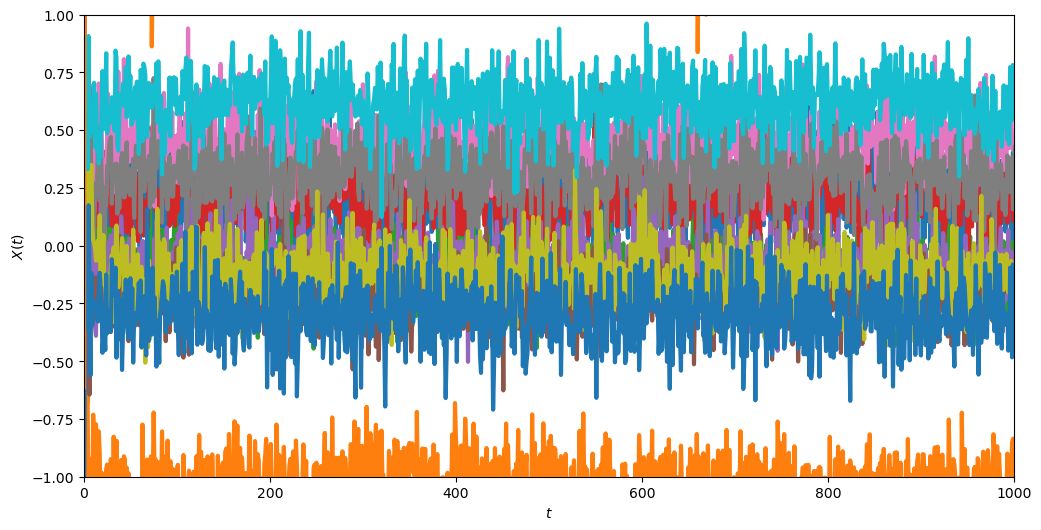

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.set_xlabel("$t$")
ax.set_ylabel("$X(t)$")
ax.set_ylim([-1.0, 1.0])
for i in range(12):
    ax.plot(t,X[i], linewidth=3)
ax.set_xlim([0.0, 1000])
fig.savefig("regular-example.png")

# Testing  the DMFT

In [5]:
from scipy import integrate
import numpy as np

step_n = 2**8 #step number
act_type = 2   #act_type = 1 (tanh), 2(sigmoid), 3(ReLU) 
error_integral = 1e-8 #tolerance level for integration 
time_slice=1 #time step
parameters3={"step_n":step_n,"act_type":act_type,"error_integral":error_integral,"time_slice":time_slice} #引数が多いので纏めておく
print(parameters3)
RRNNMF = RecurentRandomNeuralNetworkMeanField(**parameters3)

start = time.time()
print("Start")
#parameters characterizing the dynamics
v_initial = 0.01  #initial value of the variance
M_initial = 0.05  #intitial value of the mean 
g_scale = 1   #scale of the distribution of weights 
J_bias = 0.5      #bias of the weights 
theta = 0.4       #threshold for the activation function
c = 18          # parameter characterizing the gradient of the activation function
sigma_ind = 0.2   #standard deviation of independent noise

#initialization of order parameters
C=np.ones(step_n+1) 
M=np.ones(step_n+1) 

parameters4={"v_initial":v_initial,"M_initial":M_initial,
             "g_scale":g_scale,"J_bias": J_bias,"c":c,"theta":theta,"sigma_ind":sigma_ind}
print(parameters4)
C=RRNNMF.evolve_DMFT(**parameters4) #evolve_DMFT(self,v_initial,g_scale,c,theta,sigma_ind):
stop = time.time()
t=np.zeros(step_n+1)
t[0]=0
for i in range(step_n):
    t[i+1]=t[i]+time_slice
print("Time: "+str(stop-start))
print("end")


{'step_n': 256, 'act_type': 2, 'error_integral': 1e-08, 'time_slice': 1}
Start
{'v_initial': 0.01, 'M_initial': 0.05, 'g_scale': 1, 'J_bias': 0.5, 'c': 18, 'theta': 0.4, 'sigma_ind': 0.2}
0.05
error: 6.345191463899166e-09
Time: 1.3430581092834473
end


#  Hysteresis loop from DMFT


{'step_n': 128, 'act_type': 2, 'error_integral': 1e-08, 'time_slice': 1}
Start


 28%|████████████████████████████████▉                                                                                    | 36/128 [00:03<00:17,  5.29it/s]

error: 9.372656329491512e-09


 74%|██████████████████████████████████████████████████████████████████████████████████████▊                              | 95/128 [00:24<00:15,  2.17it/s]

error: 7.22272552925908e-09


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:34<00:00,  3.68it/s]


Time: 34.8280291557312
end


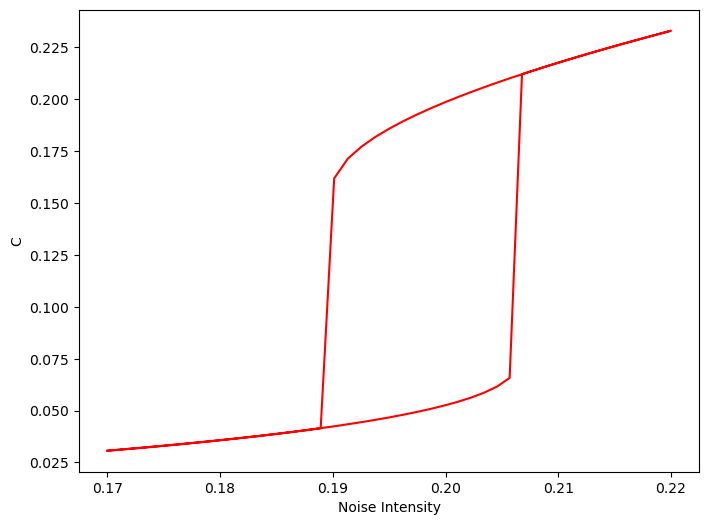

In [6]:
from scipy import integrate
import numpy as np
from tqdm import tqdm
import time

step_n = 2**7# step number
act_type = 2   #act_type = 1 (tanh), 2(sigmoid), 3(ReLU)
error_integral = 1e-8 #tolerance level for integration
time_slice=1 #time step
parameters3={"step_n":step_n,"act_type":act_type,
             "error_integral":error_integral,
             "time_slice":time_slice} 
print(parameters3)
RRNNMF = RecurentRandomNeuralNetworkMeanField(**parameters3)
points_n = step_n
start = time.time()
print("Start")
#initialize the order parameter
c_sc=np.zeros(points_n) 
m_sc=np.zeros(points_n) 
sigma_sc = np.ones(points_n)

v_initial = 0.01  #initial variance
M_initial = 0.05  #initial mean

for i in tqdm(range(points_n)):
    sigma_sc[i] =  0.17 + 0.025*(np.sin(2.0*np.pi*i/points_n - 0.5*np.pi)+1.0)
    #setting the parameter characterizing the dynamics 
    g_scale = 1.0     #scale of the distribution of weight matrix
    J_bias = 0.5      #bias of the weight
    theta = 0.5       #threshold of the activation function 
    c = 12    #parameter characterizing the gradient of the activation function
    sigma_ind = sigma_sc[i]  #standard deviation of the independent noise
    err = 1e-8 #accuracy level of the solution to the self-consistent equation 

    parameters6={"v_initial":v_initial,"M_initial":M_initial,"g_scale":g_scale,"J_bias": J_bias,"c":c,"theta":theta,"sigma_ind":sigma_ind,"err":err}

    c_sol,m_sol=RRNNMF.evolve_MFSC(**parameters6) 
    c_sc[i] = c_sol
    m_sc[i] = m_sol
    v_initial = c_sol+0.02
    M_initial = m_sol
    
stop = time.time()
print("Time: "+str(stop-start))

import matplotlib.pyplot as plt

## visualization
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(sigma_sc,c_sc, color="red")  
ax.set_xlabel("Noise Intensity")
ax.set_ylabel("C")
print("end")


#  Hysteresis loop from N-body simulation

     

In [7]:
import numpy as np
import torch
import time
from tqdm import tqdm

neuron_n = 2**13    #number of nodes
replica_n = 1       #number of replicas
step_n  = 2**12   #number of iterations
time_slice = 1  #size of discretized time step
act_type = 2        #activation function type, act_type = 1 (tanh), 2(sigmoid), 3(ReLU)
parameters1={"neuron_n":neuron_n,"replica_n":replica_n,"step_n":step_n,"time_slice":time_slice,"act_type":act_type} 
print(parameters1)
RRNNN = RecurentRandomNeuralNetworkNbody(**parameters1)

start = time.time()
sigma = torch.zeros(step_n,device = device)
print("Start")

g_scale = 1.0     #scale of the weight density function
J_bias = 0.5      #bias of the wight density function
theta = 0.5       #threshold of the activation function 
c = 12 #parameter characterizing gradient of the activation function 
noise_type = 2   #noise_type 1: white; noise_type 2: quench
sigma_common=0.0  #intensity of the white noise common to all neurons 
sigma_ind = 0.0 #initial intensity of the independent white noise if we choose noisetype 1
sigma_quench = 0.17  #initial intensity of the independent quench noise if we choose noisetype 2
sigma_move = 0.025 #varying part of the independent noise/2
initial_var=0.1  #initial variance needed to prepare the initial distribution of the x's for simulating
# initial value of the mean of x is zero, the initial value of variance is initial_var
parameters5={"g_scale":g_scale,"J_bias":J_bias,"theta":theta,"c":c,\
             "sigma_move":sigma_move,"sigma_ind":sigma_ind,"sigma_quench":sigma_quench,"noise_type":noise_type,\
             "sigma_common":sigma_common,"initial_var":initial_var} 
print(parameters5)
    
# Executing the simulation
X,sigma_N = RRNNN.evolve_rrnn_loop(**parameters5)

stop = time.time()
print("Time on GPU (torch): "+str(stop-start))

## Preparing the visualization 
X=X.cpu()
sigma_N = sigma_N.cpu()
## temporal evolution of mean and variance
vhist = np.zeros(step_n+1)
vhist = X.var(axis = 0)

mhist = np.zeros(step_n+1)
mhist = X.mean(axis = 0)


{'neuron_n': 8192, 'replica_n': 1, 'step_n': 4096, 'time_slice': 1, 'act_type': 2}
Start
{'g_scale': 1.0, 'J_bias': 0.5, 'theta': 0.5, 'c': 12, 'sigma_move': 0.025, 'sigma_ind': 0.0, 'sigma_quench': 0.17, 'noise_type': 2, 'sigma_common': 0.0, 'initial_var': 0.1}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [07:55<00:00,  8.61it/s]


Time on GPU (torch): 479.9210844039917


C:\Users\humal\AppData\Local\Temp\ipykernel_18732\2466310229.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1=plt.subplot(2,1,1)


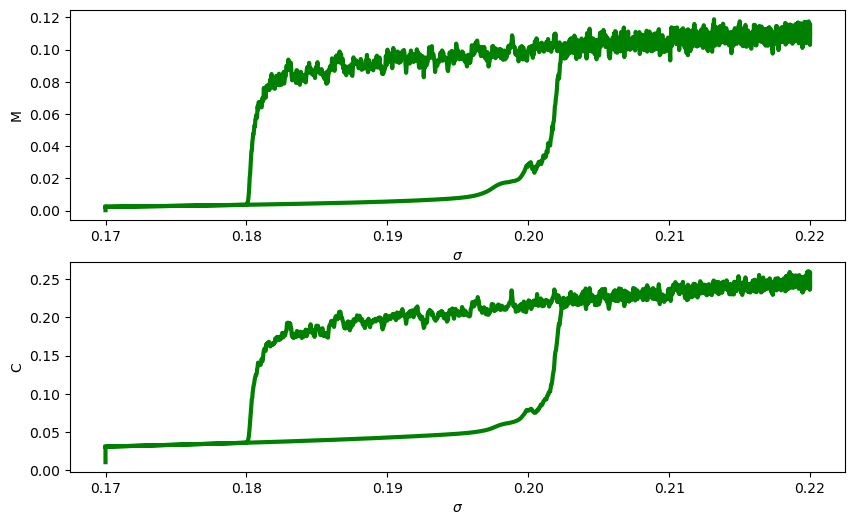

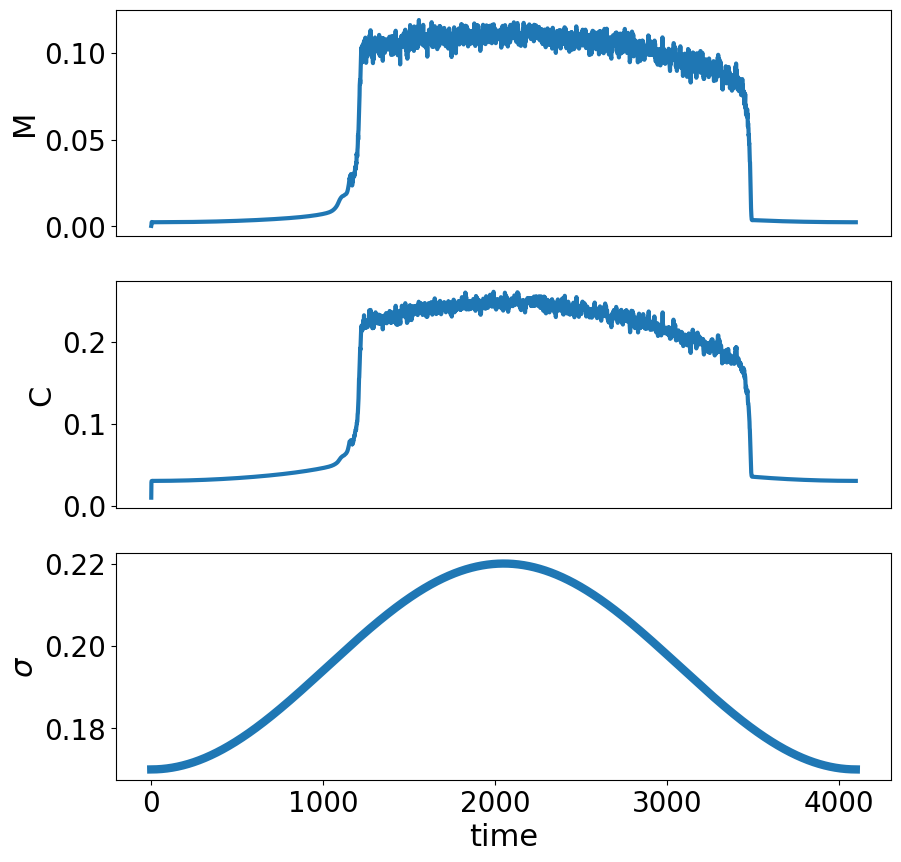

In [8]:
## visualization

lw=3
fs=22
ls=20

fig, ax = plt.subplots(1,2, figsize=(10,6)) 
ax1=plt.subplot(2,1,1) 
ax1.plot(sigma_N,mhist,linewidth=lw,color="green")
ax1.set_xlabel("$\sigma$")
ax1.set_ylabel("M")
ax2=plt.subplot(2,1,2)  
ax2.plot(sigma_N,vhist,linewidth=lw,color="green")
ax2.set_xlabel("$\sigma$")
ax2.set_ylabel("C")

fig, ax = plt.subplots(3,1, figsize=(10,10)) 

ax1=plt.subplot(3,1,1) 
ax1.plot(mhist,linewidth=lw)
ax1.set_ylabel("M",fontsize=fs)
ax1.tick_params(axis='x',labelsize=ls)
ax1.tick_params(axis='y',labelsize=ls)
ax1.set_xticks([])

ax2=plt.subplot(3,1,2) 
ax2.plot(vhist,linewidth=lw)
ax2.set_ylabel("C",fontsize=fs)
ax2.tick_params(axis='x',labelsize=ls)
ax2.tick_params(axis='y',labelsize=ls)
ax2.set_xticks([])

ax3=plt.subplot(3,1,3)  
ax3.plot(sigma_N,linewidth=lw+3)
ax3.set_ylabel("$\sigma$",fontsize=fs)
ax3.set_xlabel("time",fontsize=fs)
ax3.tick_params(axis='x',labelsize=ls)
ax3.tick_params(axis='y',labelsize=ls)

plt.savefig("hysteresis_vs_time")



# Comparing hysteresis loop from DMFT and N-body simulations


{'g_scale': 1.0, 'J_bias': 0.5, 'theta': 0.5, 'c': 12, 'sigma_move': 0.025, 'sigma_ind': 0.0, 'sigma_quench': 0.17, 'noise_type': 2, 'sigma_common': 0.0, 'initial_var': 0.1}
{'v_initial': 0.050725640348646184, 'M_initial': 0.0023592565250951923, 'g_scale': 1.0, 'J_bias': 0.5, 'c': 12, 'theta': 0.5, 'sigma_ind': 0.1700301135948707, 'err': 1e-08}


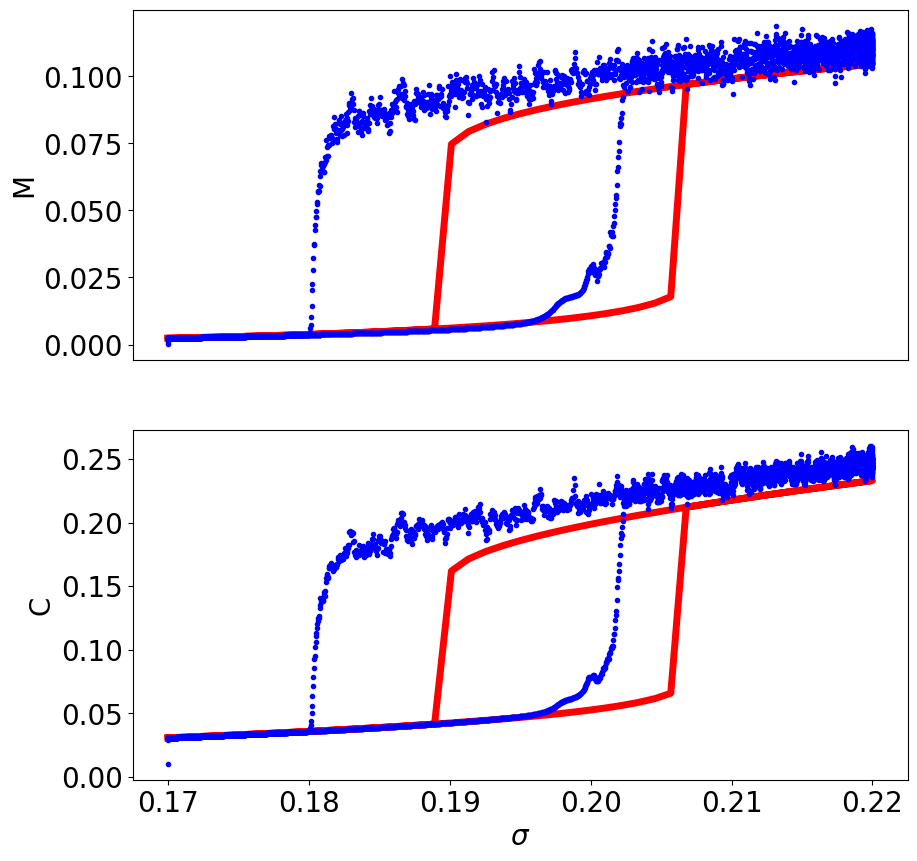

In [9]:

print(parameters5)
print(parameters6)
import matplotlib.pyplot as plt

## visualization
fig, ax = plt.subplots(2, 1, figsize=(10,10))

ms=3
lw=5
fs=20
ls=20

ax1=ax[0]
ax1.plot(sigma_sc,m_sc, color="red",linewidth=lw)  #showing results of DMFT
ax1.plot(sigma_N,mhist,"bo",markersize=ms)#showing results N-body simulation
ax1.set_ylabel("M",fontsize=fs)
ax1.tick_params(axis='y',labelsize=ls)
ax1.set_xticks([])

ax2=ax[1]
ax2.plot(sigma_sc,c_sc, color="red",linewidth=lw)  #showing results of DMFT
ax2.plot(sigma_N,vhist,"bo",markersize=ms)# showing results of N-body simulation 
ax2.set_xlabel("$\sigma$",fontsize=fs)
ax2.set_ylabel("C",fontsize=fs)
ax2.tick_params(axis='y',labelsize=ls)
ax2.tick_params(axis='x',labelsize=ls)

plt.savefig("hysteresis_vs_sigma")